In [1]:
import bz2
import pandas as pd

# قراءة جزء من بيانات التدريب فقط (10 آلاف مثال) للتجربة السريعة
with bz2.open("train.ft.txt.bz2", "rt", encoding="utf-8") as f:
    lines = []
    for i, line in enumerate(f):
        if i >= 10000: break
        lines.append(line)

# تقسيم الـ lines إلى label و text
data = [{'label': row.split(' ',1)[0], 'text': row.split(' ',1)[1].strip()} for row in lines]
df = pd.DataFrame(data)
df['label'] = df['label'].map({'__label__1': 0, '__label__2': 1})
print(df['label'].value_counts(), len(df))


0    5097
1    4903
Name: label, dtype: int64 10000


In [2]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# تأكد من تثبيت stopwords
import nltk; nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|[^a-zA-Z\s]", "", text)
    tokens = text.split()
    cleaned = [stemmer.stem(w) for w in tokens if w not in stop_words and len(w)>1]
    return " ".join(cleaned)

df['clean_text'] = df['text'].apply(preprocess)
print(df[['text','clean_text']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                text  \
0  Stuning even for the non-gamer: This sound tra...   
1  The best soundtrack ever to anything.: I'm rea...   
2  Amazing!: This soundtrack is my favorite music...   
3  Excellent Soundtrack: I truly like this soundt...   
4  Remember, Pull Your Jaw Off The Floor After He...   

                                          clean_text  
0  stune even nongam sound track beauti paint sen...  
1  best soundtrack ever anyth im read lot review ...  
2  amaz soundtrack favorit music time hand intens...  
3  excel soundtrack truli like soundtrack enjoy v...  
4  rememb pull jaw floor hear youv play game know...  


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['label']


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1037
           1       0.83      0.84      0.83       963

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



In [6]:
def predict_sentiment(review):
    clean = preprocess(review)
    vec = vectorizer.transform([clean])
    pred = model.predict(vec)[0]
    return "Positive 😊" if pred==1 else "Negative ☹️"

for sample in [
    "This product is fantastic, absolutely loved it!",
    "Terrible experience, broke after one use."
]:
    print(sample, "→", predict_sentiment(sample))


This product is fantastic, absolutely loved it! → Positive 😊
Terrible experience, broke after one use. → Negative ☹️


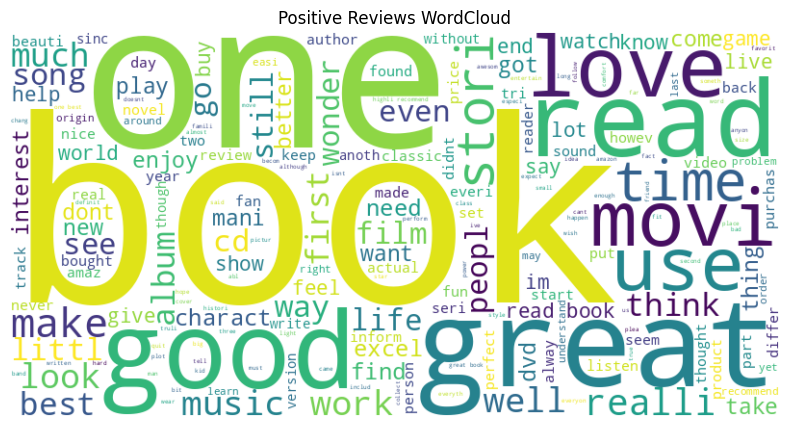

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

pos = " ".join(df[df['label']==1]['clean_text'])
wc = WordCloud(width=800, height=400, background_color='white').generate(pos)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Reviews WordCloud")
plt.show()


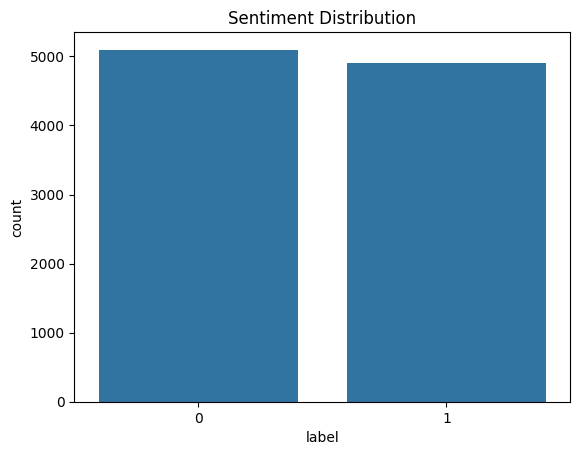

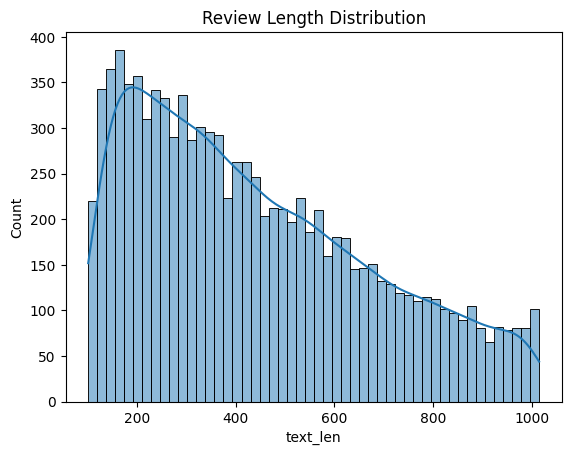

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# توزيع الفئات
sns.countplot(x='label', data=df)
plt.title("Sentiment Distribution")
plt.show()

# طول النصوص
df['text_len'] = df['text'].apply(len)
sns.histplot(df['text_len'], bins=50, kde=True)
plt.title("Review Length Distribution")
plt.show()


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

# تأكد إن X_train و X_test عبارة عن النصوص الأصلية أو النظيفة
vectorizer = TfidfVectorizer(max_features=5000)

X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['clean_text'],
    df['label'],
    test_size=0.2,
    random_state=42
)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train_text)
X_test_vec = vectorizer.transform(X_test_text)


In [41]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

models = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Naive Bayes': MultinomialNB(),
    'SVM': LinearSVC(),
    'Random Forest': RandomForestClassifier()
         }

# قبل اللوب
model_predictions = {}

# اللوب نفسه
for name, clf in models.items():
    clf.fit(X_train_vec, y_train)
    y_pred = clf.predict(X_test_vec)
    model_predictions[name] = y_pred
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))


Logistic Regression Accuracy: 0.8400
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1037
           1       0.83      0.84      0.83       963

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000

Naive Bayes Accuracy: 0.8250
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1037
           1       0.83      0.80      0.81       963

    accuracy                           0.82      2000
   macro avg       0.83      0.82      0.82      2000
weighted avg       0.83      0.82      0.82      2000

SVM Accuracy: 0.8315
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1037
           1       0.82      0.83      0.83       963

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.

In [49]:
logistic_pred = model_predictions['Logistic Regression']
# naive_pred = model_predictions['Naive Bayes']
# svm_pred = model_predictions['SVM']
# random_pred = model_predictions['Random Forest']

wrong = np.where(logistic_pred != y_test)[0]

for i in wrong[:5]:
    print(f"\n❌ Predicted: {logistic_pred[i]}, ✅ Actual: {y_test.iloc[i]}")
    print(f"📝 Review: {X_test_text.iloc[i]}")



❌ Predicted: 1, ✅ Actual: 0
📝 Review: write good plot need lot work love book make laugh friend told book paid full price feel somewhat ms jensen gift humor plot involv book horribl good humor element believ book none whatsoev believ stori line ms jensen could among top humor writer

❌ Predicted: 1, ✅ Actual: 0
📝 Review: great first timer flexabl nice use non standard tripl batteri uncommon vibrat size actual littl small twist insid would recommend ladi like small first timer

❌ Predicted: 1, ✅ Actual: 0
📝 Review: enter video enter videono storylinesmuch lesser wrestler enjoy play mode pleas next time think thing enjoy play gba

❌ Predicted: 1, ✅ Actual: 0
📝 Review: simpl mind bought book review shock one becom author simpli steal life experi stori peopl live felt book shallow perfect peopl couldnt think human half brain see empti content book

❌ Predicted: 1, ✅ Actual: 0
📝 Review: lacklust uninform dvd present content video leav lot desir visual aid diagram etc profession done refer 

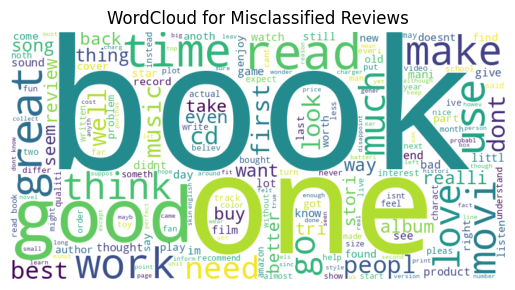

In [50]:
wrong_reviews = [X_test_text.iloc[i] for i in wrong]
text_wrong = " ".join(wrong_reviews)
wc = WordCloud(width=800, height=400, background_color='white').generate(text_wrong)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud for Misclassified Reviews")
plt.show()


In [51]:
from sklearn.pipeline import Pipeline

final_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=5000)),
    ('classifier', LogisticRegression(max_iter=200))
])

final_pipeline.fit(X_train_text, y_train)
joblib.dump(final_pipeline, 'model/sentiment_pipeline.pkl')


['model/sentiment_pipeline.pkl']

In [52]:
pipe = joblib.load('model/sentiment_pipeline.pkl')
pred = pipe.predict([review])[0]


In [53]:
with bz2.open("train.ft.txt.bz2", "rt", encoding="utf-8") as f:
    lines = f.readlines()


In [54]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|[^a-zA-Z\s]", "", text)
    tokens = text.split()
    cleaned = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w)>1]
    return " ".join(cleaned)


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/azureuser/nltk_data...


In [55]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))


In [56]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

grid = GridSearchCV(LogisticRegression(max_iter=300), param_grid, cv=3, n_jobs=-1)
grid.fit(X_train_vec, y_train)

print("أفضل بارامترات:", grid.best_params_)
y_pred = grid.predict(X_test_vec)

from sklearn.metrics import accuracy_score, classification_report

print("دقة بعد التظبيط:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


أفضل بارامترات: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
دقة بعد التظبيط: 0.84
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1037
           1       0.83      0.84      0.83       963

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



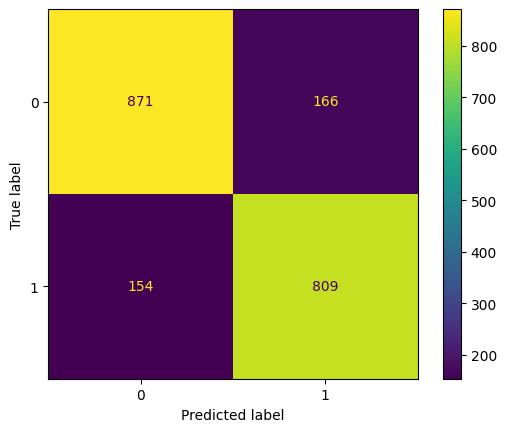

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


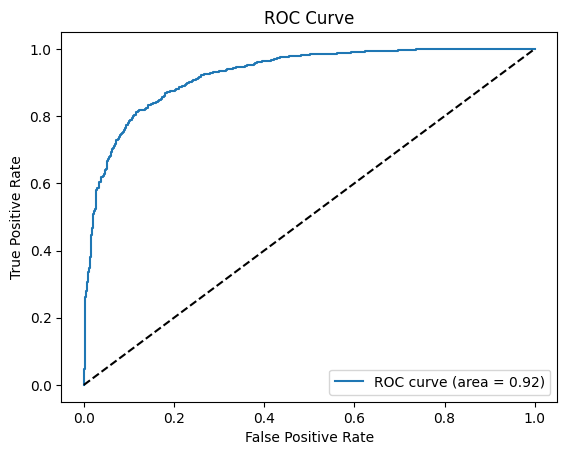

In [65]:
from sklearn.metrics import roc_curve, auc

y_prob = grid.predict_proba(X_test_vec)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [66]:
joblib.dump(grid.best_estimator_, "model/best_logistic_model.pkl")


['model/best_logistic_model.pkl']